#### Import libraries

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

In [ ]:
# ## DASK client instructions not currently used

# from dask.distributed import Client

# client = Client("tcp://192.168.44.105:33903")
# client

#### File list and Dates

In [2]:
#path to netCDF files *NOTE, only want int.nc (saved as integers in [cm])
path = '/srv/shared/deep_stac/data/snowdepth/netcdf/20*/*int.nc'
# path = '/home/jovyan/netcdf/20*/*int.nc'

#filelist, 2015 & 2017
flist = glob.glob(path, recursive=True)
flist=sorted(flist)

#parses dates, stored as pandas datetime type in list
fparse = [d.split('/')[-1] for d in flist] #splits fname on '/' saves last
fparse = [d.split('_')[0] for d in fparse] #splitting fname on '_' and saves first
dates = pd.to_datetime(fparse) #pandas datetime variable of all lidar dates

#### Open and clean up lidar-derived Snow Depths
    ds = entire dataset: 10 lidar flights from 2015, 9 lidar flights from 2017
    
    dimensions = label given to coordinate values
    coordinates = values in a dimension, stored as python dictionaries
    
    Note - 
        dates = pandas datetime type computed above
        time = new coordinate assigned to xarray, labels vertically by giving a 'time' dimension 
        
    Throws a warning message but seems to work right

In [ ]:
#load xarray (*note, gives an error, it's okay!)
ds=xr.open_mfdataset(flist, concat_dim='time', chunks={'x':1000, 'y':1000}) #dataset
## remove unneeded transverse mercator variable
ds = ds.drop('transverse_mercator')
#add 'time' coordinate #note, by default this populates with a dimension called 'time'
ds['time'] = (['time'], dates)
# rename Band1 "snow"
ds.rename({'Band1' : 'snow'}, inplace=True)
#flip snow up/down so it matches topo.nc
ds['snow'].values = ds.snow[::-1]
ds.close()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  


#### Open and clean up topographic data and mask

In [9]:
## start by opening up netcdf 
path_to_topo = '/srv/shared/deep_stac/data/topo.nc'
temp = xr.open_dataset(path_to_topo,chunks={'x':1000, 'y':1000})
##temp = xr.open_dataset(path_to_topo, chunks={'x':1000, 'y':1000})
temp.close()

## select variables of interest. 'mask' is for area of interest, 0 elsewhere
add_to_lidar = ['dem','veg_height','mask']
## dtopo is the dataset with only the desired variables
dtopo = temp[add_to_lidar]
dtopo.close()


#### Combine snow and topographic files in one xarray
    'ds' is final xarray
    code prints attributes of ds

In [10]:
# add in topo variables
ds['dem'] = (['y','x'],dtopo.dem)
ds['veg'] = (['y','x'],dtopo.veg_height)
ds['mask'] = (['y','x'],dtopo.mask)
# show attributes
# print(ds)

#### Save as netcdf file for further analysis

In [ ]:
### THIS SEEMS TO TAKE FOREVER SO I DIDN'T DO IT

#dataDIR = '~/srv/shared/deep_stac/snotopo.nc'
# dataDIR = '/home/jovyan/snotopo.nc'
# print(dataDIR)
# ds.to_netcdf(path=dataDIR,mode='w')

#### Experimenting with plotting and filtering

In [11]:
ds

<xarray.Dataset>
Dimensions:  (time: 19, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
  * time     (time) datetime64[ns] 2015-02-18 2015-03-06 ... 2017-08-16
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(19, 17002, 17569), chunksize=(1, 1000, 1000)>
    dem      (y, x) float32 2633.369 2635.3313 2635.3313 ... 3064.8484 3064.3577
    veg      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 17.5 17.5 17.5 17.5 17.5
    mask     (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.4.1, released 2019/03/15
    history:             Wed Sep 11 15:42:33 2019: GDAL CreateCopy( /srv/shar...

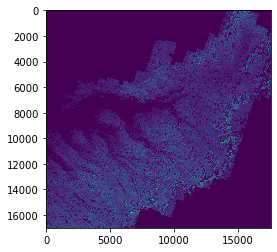

In [12]:
plt.figure()
plt.imshow(ds.isel(time=12).snow)
plt.show()

In [10]:
# find images extents for plot axis
xmin = np.min(ds['x'].values)
xmax = np.max(ds['x'].values)
ymin = np.min(ds['y'].values)
ymax = np.max(ds['y'].values)
extents = [xmin,xmax,ymin,ymax]

In [ ]:
# Plot one time in the masked region for elevation above 2900m (treeline)
d = ds.isel(time=0).snow.where(ds.dem > 2900).where(ds.mask==1)
plt.imshow(d, extent=extents, vmax=250)
plt.colorbar()
plt.title('2015-02-18, Snow Depth in Tuolumne Basin')

In [ ]:
# Find mean snow depth for all time slices in 2015
d = ds.sel(time='2015').snow
mean2015=ds.sel(time='2015').snow.mean(dim='time')
print((mean2015.shape))
# remove snow-free areas
mean2015=mean2015>0
mean2015.shape
plt.imshow(mean2015>0, origin='lower')

In [ ]:
# Plot a slice of the sixth snow depth measurement 
ds.snow.isel(time=5, x = slice(10000,10500), y=slice(10000,10500)).plot()

In [ ]:
# Plot snowdepth for one time interval only above 2900 m
# this grabs snow depth for all time intervals
snow2900 = ds.snow.where(ds.dem > 2900)


# plot only for one time interval
plt.imshow(snow2900[0], extent=[xmin, xmax, ymin, ymax])

In [ ]:
# create new dataset for all observations in a given year
ds15 = ds.sel(time='2015')

In [ ]:
# calculate standard deviation of snow depths in 2015
std = ds.sel(time='2015').snow.std(dim='time')

# mean_sd_15 = ds15.snow.std(dim='flights')
fig = plt.figure(figsize=(15, 10))
plt.imshow(std, origin='lower', cmap='jet')#, vmin=.01, vmax=2.0)
plt.colorbar()
plt.show()


In [ ]:
ds

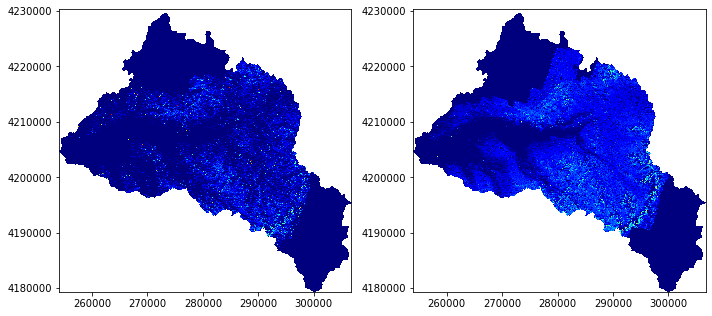

In [15]:
# Peak SWE date comparison
    #2015: March 6th time=1
    #2017: April 1st time=12

#2015
d1 = ds.isel(time=1).snow.where(ds.mask==1)
d1.close()

#2017
d2 = ds.isel(time=12).snow.where(ds.mask==1)
d1.close()

#plot
fig, [ax1,ax2]=plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(d1, extent=extents, cmap='jet')#, vmax=250)
ax2.imshow(d2, extent=extents, cmap='jet')#, vmax=250)
# plt.colorbar()
# plt.title('2015-02-18, Snow Depth in Tuolumne Basin')


plt.tight_layout()
plt.show()


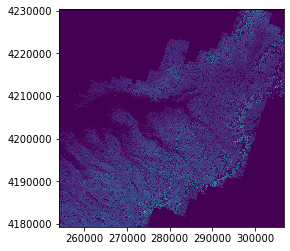

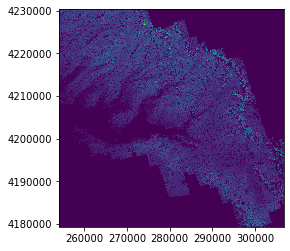

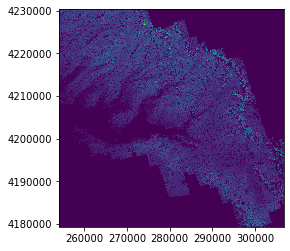

In [13]:
plt.figure()
plt.imshow(ds.isel(time=12).snow, extent=extents)
plt.show()

plt.figure()
plt.imshow(ds.isel(time=12).snow[::-1], extent=extents)
plt.show()

plt.figure()
plt.imshow(ds.isel(time=12).snow, origin='lower', extent=extents)
plt.show()